In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,sklearn,tf,keras:
    print(module.__name__,module.__version__)

Using TensorFlow backend.


2.1.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
sklearn 0.22.1
tensorflow 2.1.0
keras 2.3.1


In [2]:
train_dir = os.path.join("plantseeding/train" )
test_dir = os.path.join("plantseeding/test" )
label_file = os.path.join("plantseeding/sample_submission.csv" )
print(os.path.exists(train_dir))
print(os.path.exists(test_dir))
print(os.path.exists(label_file))

True
True
True


In [3]:
label = pd.read_csv(label_file,header=0)
print(label)

              file     species
0    0021e90e4.png  Sugar beet
1    003d61042.png  Sugar beet
2    007b3da8b.png  Sugar beet
3    0086a6340.png  Sugar beet
4    00c47e980.png  Sugar beet
..             ...         ...
789  fea355851.png  Sugar beet
790  fea3da57c.png  Sugar beet
791  fef2ade8c.png  Sugar beet
792  ff65bc002.png  Sugar beet
793  ffc6f8527.png  Sugar beet

[794 rows x 2 columns]


In [4]:
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 12

trian_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
train_generator = trian_datagen.flow_from_directory(train_dir,
                                                  target_size = (height,width),
                                                  batch_size = batch_size,
                                                  seed = 7,
                                                  shuffle = True,
                                                  class_mode = "categorical")
test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)
test_generator = test_datagen.flow_from_directory(train_dir,
                                                  target_size = (height,width),
                                                  batch_size = batch_size,
                                                  seed = 7,
                                                  shuffle = False,
                                                  class_mode = "categorical")
train_num = train_generator.samples
test_num = test_generator.samples
print(train_num,test_num)

Found 4750 images belonging to 12 classes.
Found 4750 images belonging to 12 classes.
4750 4750


In [5]:
for i in range(2):
    x,y = train_generator.next()
    print(x.shape,y.shape)
    print(y)

(24, 224, 224, 3) (24, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(24, 224, 224, 3) (24, 12)
[[1. 0. 0

In [6]:
resnet50 = keras.applications.ResNet50(include_top = False,
                                       pooling = 'avg',
                                       weights = 'imagenet')

for layer in resnet50.layers[0:-5]:
    layer.trainable = False
    
resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes,activation = 'softmax'),
])

resnet50_new.compile(loss = "categorical_crossentropy",
             optimizer = "sgd",
             metrics = ['accuracy'])
resnet50_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 12)                24588     
Total params: 23,612,300
Trainable params: 1,079,308
Non-trainable params: 22,532,992
_________________________________________________________________


In [9]:
epochs = 10
logdir = os.path.join("ResNetNew_50epchos_result" )
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "ResNetNew_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only = True)
]
history = resnet50_new.fit_generator(train_generator,
                                          steps_per_epoch = train_num//batch_size,
                                          epochs = epochs,
                                          validation_data = test_generator,
                                          validation_steps = test_num//batch_size
                                          )

Epoch 1/10
197/197 [==============================] - 1800s 9s/step - loss: 0.7457 - accuracy: 0.7603 - val_loss: 0.1920 - val_accuracy: 0.5104
Epoch 2/10
197/197 [==============================] - 1758s 9s/step - loss: 0.6934 - accuracy: 0.7776 - val_loss: 0.8579 - val_accuracy: 0.5051
Epoch 3/10
197/197 [==============================] - 1758s 9s/step - loss: 0.6435 - accuracy: 0.7950 - val_loss: 0.3667 - val_accuracy: 0.5438
Epoch 4/10
197/197 [==============================] - 1757s 9s/step - loss: 0.6116 - accuracy: 0.8043 - val_loss: 1.3798 - val_accuracy: 0.5186
Epoch 5/10
197/197 [==============================] - 1760s 9s/step - loss: 0.5799 - accuracy: 0.8199 - val_loss: 0.8112 - val_accuracy: 0.5252
Epoch 6/10
197/197 [==============================] - 1756s 9s/step - loss: 0.5721 - accuracy: 0.8204 - val_loss: 0.8757 - val_accuracy: 0.5442
Epoch 7/10
197/197 [==============================] - 1756s 9s/step - loss: 0.5395 - accuracy: 0.8212 - val_loss: 0.7855 - val_accuracy:

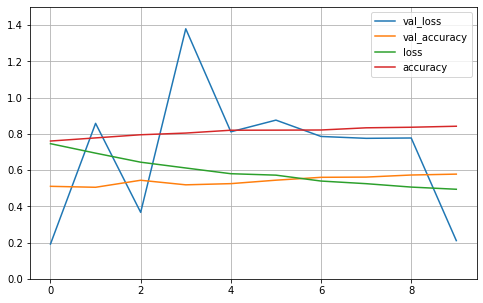

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1.5)
    plt.show()
    
plot_learning_curves(history)